In [1]:
# Install google-play-scraper
pip install google-play-scraper pandas python-dateutil

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Collecting the Spotify reviews from the Google Play Store

# Imports
import time
from datetime import datetime, timezone, timedelta
import pandas as pd
from google_play_scraper import reviews, Sort

# Google Play scraping parameters
APP_ID  = "com.spotify.music" # Spotify Android app package name
LANG    = "en"                # Only get reviews written in English
COUNTRY = "us"                # Only get reviews from the US Google Play Store

# Time windows for the before/after update comparison
PRE_END_DATE    = datetime(2025, 9, 14, tzinfo=timezone.utc) # Last day considered 'pre-update'
POST_START_DATE = datetime(2025, 9, 15, tzinfo=timezone.utc) # first day considered 'post-update'

POST_CAP = 800   # collect at most this many post reviews
PRE_CAP  = 800   # collect at most this many pre reviews

BATCH_SIZE = 200 # Number of reviews requested per API call
PAUSE_SEC  = 0.8 # Delay between requests to avoid errors
OLD_LIMIT = timedelta(days=120)  # stop if we've paged more than 120 days past PRE_END_DATE

# Helps set all timezones to utc
def to_utc(dt):
    if dt is None:
        return None
    return dt if dt.tzinfo else dt.replace(tzinfo=timezone.utc)

# Basic cleaning and filtering for dataframe
def basic_clean(df):
    if df.empty: return df
    df["content"] = df["content"].astype(str) 
    wc = df["content"].str.split().str.len().fillna(0) 
    df = df[wc >= 10].drop_duplicates(subset=["content"]) # keep only reviews that have at least 10 words, and remove duplicate reviews
    return df.sort_values("at", ascending=False).reset_index(drop=True) #sort reviews by timestamp

# fetch reviews from Google Play store
def fetch_reviews():
    post_rows, pre_rows = [], []
    cursor = None
    batches = 0 # initialize the number of batches we fetched
    phase = "post"  # collect reviews from after the update first

    while True:
        # batch fetch reviews sorted from newest to older, cursor keeps track of fetch progress until all reviews are fetched
        batch, cursor = reviews(
            APP_ID, lang=LANG, country=COUNTRY,
            sort=Sort.NEWEST, count=BATCH_SIZE,
            continuation_token=cursor
        )
        if not batch: break
        batches += 1 #increment number of fetch requests

        oldest_seen = None # initialize

        #Go through each review in the batch
        for r in batch:
            rating = r.get("score")
            if rating is None or rating > 3:  # keep low ratings only
                continue

            at_utc = to_utc(r.get("at")) # convert to utc
            if at_utc is None:           # skip reviews with no timestamps
                continue

            # update to oldest seen review so far
            if oldest_seen is None or at_utc < oldest_seen:
                oldest_seen = at_utc

            # Extract the useful fields
            row = {
                "reviewId": r.get("reviewId"),
                "rating": rating,
                "thumbsUpCount": r.get("thumbsUpCount"),
                "at": at_utc,
                "content": r.get("content") or "",
                "replyContent": r.get("replyContent") or "",
                "reviewCreatedVersion": r.get("reviewCreatedVersion") or "",
                "country": COUNTRY, "lang": LANG
            }

            if phase == "post":
                # collect only post update reviews until POST_CAP
                if at_utc >= POST_START_DATE:
                    if len(post_rows) < POST_CAP:
                        post_rows.append(row)
                elif at_utc <= PRE_END_DATE:
                    # Skip reviews in pre-update window
                    pass
            else:
                # collect reviews for before the update, unless cap is reached
                if at_utc <= PRE_END_DATE and len(pre_rows) < PRE_CAP:
                    pre_rows.append(row)

        # switch to before the update once we either hit POST_CAP or we are already paging into pre dates
        if phase == "post" and (len(post_rows) >= POST_CAP or (oldest_seen and oldest_seen <= PRE_END_DATE)):
            phase = "pre"

        # stopping conditions
        if phase == "pre":
            # stop when pre update cap hit or when reviews are too old
            if len(pre_rows) >= PRE_CAP:
                break
            if oldest_seen and (PRE_END_DATE - oldest_seen) > OLD_LIMIT:
                break

        # stop when no more pages to fetch
        if cursor is None:
            break

        # pause a bit between requests
        time.sleep(PAUSE_SEC)

    # return records seperated into pre update and post update windows
    pre_df  = basic_clean(pd.DataFrame(pre_rows)).drop_duplicates(subset=["reviewId"])
    post_df = basic_clean(pd.DataFrame(post_rows)).drop_duplicates(subset=["reviewId"])
    return pre_df, post_df

# Run the review collection, save cleaned and balanced datasets to CSV 
if __name__ == "__main__":
    pre_df, post_df = fetch_reviews()
    print(f"Reviews kept: PRE={len(pre_df)} POST={len(post_df)}")
    pre_df.to_csv("spotify_googleplay_pre_2025-09-14_leq3_balanced.csv", index=False)
    post_df.to_csv("spotify_googleplay_post_2025-09-15_leq3_balanced.csv", index=False)





Reviews kept: PRE=494 POST=534


In [53]:
# Configuration

# Setting random seed
RNG = 42

# set file path names
PRE_PATH  = "spotify_googleplay_pre_2025-09-14_leq3_balanced.csv"
POST_PATH = "spotify_googleplay_post_2025-09-15_leq3_balanced.csv"

In [55]:
# Imports 
import re, random, numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords") 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA

random.seed(RNG); np.random.seed(RNG)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15714\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# Load in data
pre  = pd.read_csv(PRE_PATH, parse_dates=["at"])
post = pd.read_csv(POST_PATH, parse_dates=["at"])

# Keep columns I want to look at
cols = ["reviewId","at","rating","thumbsUpCount","country","content"]
pre, post = pre[cols].copy(), post[cols].copy()

# checking what data we have
print("Rows before/after update:", len(pre), len(post))
print("Date span before update:", pre["at"].min(), pre["at"].max())
print("Date span after update:", post["at"].min(), post["at"].max())

# Make sure the number of samples for pre and post updates are equal and random
n = min(len(pre), len(post))
pre_bal  = pre.sample(n=n, random_state=RNG)
post_bal = post.sample(n=n, random_state=RNG)

# combine into one dataframe
pre_bal["window"]  = "pre"
post_bal["window"] = "post"
df = pd.concat([pre_bal, post_bal], ignore_index=True)

# check how many reviews once balanced
counts = df["window"].value_counts()
print("pre-update reviews:", counts.get('pre',0))
print("post-update reviews:", counts.get('post',0))

Rows before/after update: 494 537
Date span before update: 2025-09-10 11:06:58+00:00 2025-09-13 23:51:22+00:00
Date span after update: 2025-11-13 03:41:35+00:00 2025-11-15 19:26:23+00:00
pre-update reviews: 494
post-update reviews: 494


In [59]:
# Text cleaning

# lowercase, remove urls, remove punctuation 
def basic_clean_text(s: str) -> str:
    s = str(s).lower()
    # looked up regex expressions to use
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s'’-]", " ", s)  # keep common apostrophes, dashes, and numbers
    s = re.sub(r"\s+", " ", s).strip()     # remove white space
    return s

df["clean"] = df["content"].apply(basic_clean_text)

In [75]:
CUSTOM_STOP = {
    # add custom stop words for words that mask real complaints
    "spotify","music","song","songs","listen","listening","app","apps",
    "please","really","dont","didnt","cant","wont","youre","ive","im"
}

# Make stop words include nltk stopwords and custom stopwords
STOP_WORDS = list(set(stopwords.words("english")).union(CUSTOM_STOP))

# Use counts for lda
cv = CountVectorizer(
    analyzer="word", # split text into words
    lowercase=True, # covert everything to lowercase
    strip_accents="unicode", # normalize accents
    # regex expression for starting with letter a-z, has at least two characters, filters out numbers/punctuation
    token_pattern=r"(?u)\b[a-z][a-z']+\b", 
    ngram_range=(1,2), # use unigrams and bigrams
    min_df=5, # only keep terms that appear in at least 5 reviews
    max_df=0.95, # dont keep terms if they appear in more than 95% of reviews
    stop_words=STOP_WORDS # remove stopword list
)

# build matrix of word/phrase counts and store corresponding text terms
Xc = cv.fit_transform(df["clean"])
vocab = np.array(cv.get_feature_names_out())

# pick best K val by readability
K_OPTIONS = [8,9,10]

for k in K_OPTIONS:
    lda = LDA(
        n_components=k, 
        random_state=42, 
        learning_method="batch", 
        max_iter=20
    )
    W = lda.fit_transform(Xc) # document–topic matrix
    H = lda.components_ # topic–term matrix
    print(f"\nK={k}")
    for t in range(k):
        # sorts term indices for this topic by weight
        top_idx = np.argsort(H[t])[::-1][:12]
        print(f"Topic {t}: {', '.join(vocab[top_idx])}")



K=8
Topic 0: premium, plan, can't, like, choose, day, want, lossless, get, even, find, features
Topic 1: artists, experience, use, premium, worst, service, free, times, subscription, money, ads, many
Topic 2: premium, can't, even, without, play, can't even, ads, without premium, want, get, buy, buy premium
Topic 3: like, play, want, pay, feature, playing, even, premium, podcasts, shuffle, get, need
Topic 4: phone, fix, playing, work, stop, update, even, keep, bad, still, issue, load
Topic 5: ads, premium, every, like, ad, many, one, minutes, get, free, time, many ads
Topic 6: playlist, play, time, shuffle, back, every, good, order, even, want, one, update
Topic 7: free, version, new, user, use, like, ads, playlists, make, price, free version, years

K=9
Topic 0: can't, premium, play, even, want, can't even, choose, without, day, pay, limited, can't play
Topic 1: years, ads, experience, artists, service, change, times, still, many, premium, de, la
Topic 2: premium, account, still, even

In [78]:
#decided on k=8
K = 8
# get final matrices for k = 8
lda = LDA(
        n_components=K, 
        random_state=42, 
        learning_method="batch", 
        max_iter=20
        )
W = lda.fit_transform(Xc) # document–topic matrix
H = lda.components_ # topic–term matrix

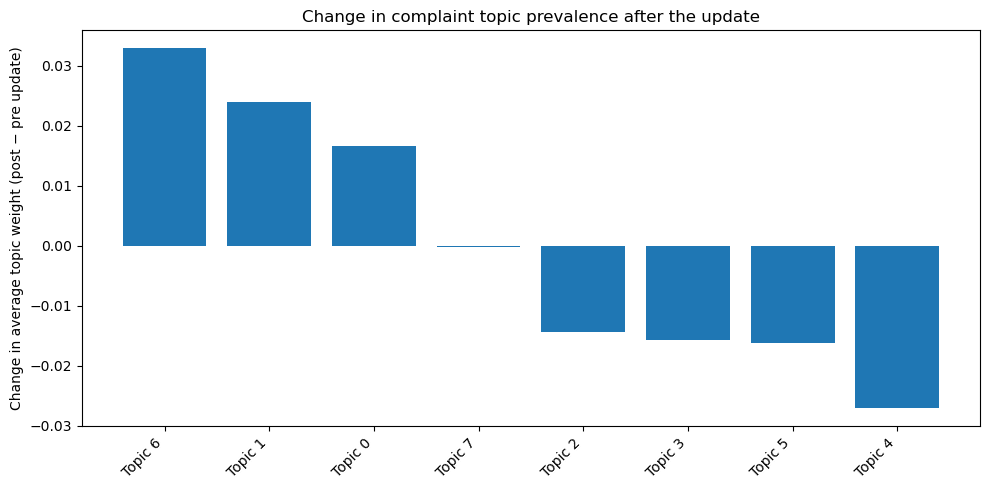

In [79]:
# Topic prevalence

# store topic weights for each review
Z = pd.DataFrame(W, columns=[f"topic_{t}" for t in range(K)])
# make sure we know whther review is from before/after update
Z["window"] = df["window"].values

#compute avg topic weight for pre and post update reviews
pre_prev  = Z[Z["window"]=="pre"].drop(columns="window").mean()
post_prev = Z[Z["window"]=="post"].drop(columns="window").mean()
# compute how much avg weight changed
delta = (post_prev - pre_prev).sort_values(ascending=False)

# Plot
labels = [topic_labels.get(int(k.split("_")[1]), k) for k in delta.index]
plt.figure(figsize=(10,5))
plt.bar(range(len(delta)), delta.values)
plt.xticks(range(len(delta)), labels, rotation=45, ha="right")
plt.ylabel("Change in average topic weight (post − pre update)")
plt.title("Change in complaint topic prevalence after the update")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/delta_topic_prevalence.png", dpi=150)
plt.show()

In [65]:
!pip install wordcloud

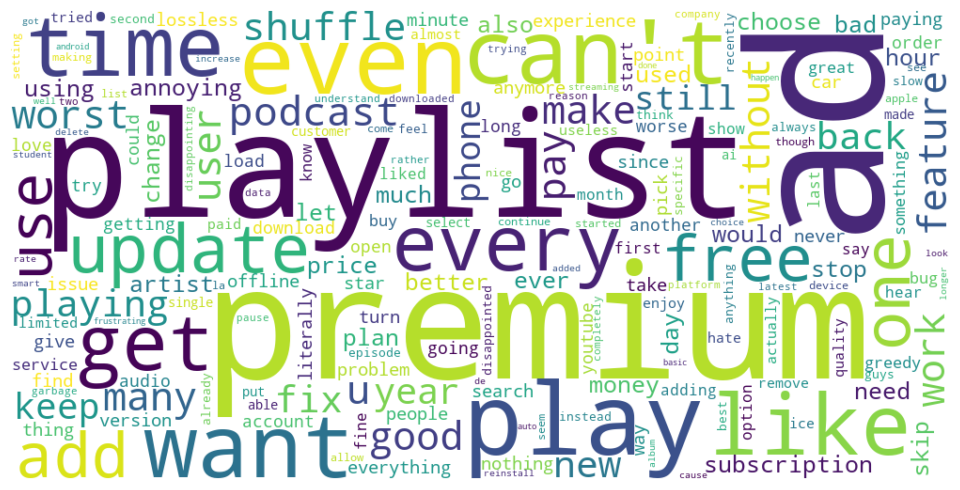

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_post = " ".join(df[df["window"]=="post"]["clean"].tolist())

# make word cloud for before and after update
wc = WordCloud(
    width=1000, height=500,
    background_color="white",
    stopwords=set(STOP_WORDS),
    collocations=False  
).generate(text_post)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()